# Exercise 4 - Sunspots

This week you moved away from synthetic data to do a real-world prediction -- sunspots. You loaded data from CSV and built models to use it. For this week’s exercise, you’ll use a dataset from Jason Brownlee, author of the amazing MachineLearningMastery.com site and who has shared lots of datasets at https://github.com/jbrownlee/Datasets. It’s a dataset of daily minimum temperatures in the city of Melbourne, Australia measured from 1981 to 1990.  Your task is to download the dataset, parse the CSV, create a time series and build a prediction model from it. Your model should have an MAE of less than 2, and as you can see in the output, mine had 1.78. I’m sure you can beat that! :)



## Imports and functions

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Get data

In [5]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-08-31 02:34:36--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2020-08-31 02:34:37 (4.18 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



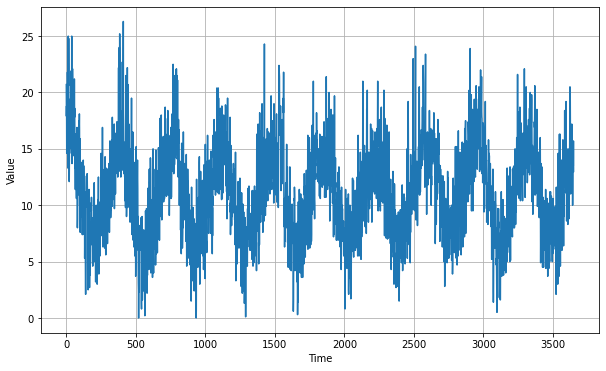

In [6]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  file = csv.reader(csvfile)
  headers = next(file)
  for i,row in enumerate(file):
    time_step.append(int(i))
    temps.append(float(row[1]))

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

## Model

In [41]:
split_time = 2500
time_train = time_step[:split_time]
x_train = series[:split_time]
time_valid = time_step[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


### 1. Find Learning Rate

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                            strides=1, padding="causal",
                            activation="relu",
                            input_shape=[None, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 20ms/step - loss: 31.1571 - mae: 31.6550
Epoch 2/100
10/10 [==============================] - 0s 25ms/step - loss: 30.5778 - mae: 31.0756
Epoch 3/100
10/10 [==============================] - 0s 27ms/step - loss: 29.6825 - mae: 30.1801
Epoch 4/100
10/10 [==============================] - 0s 25ms/step - loss: 28.5613 - mae: 29.0586
Epoch 5/100
10/10 [==============================] - 0s 27ms/step - loss: 27.1974 - mae: 27.6945
Epoch 6/100
10/10 [==============================] - 0s 24ms/step - loss: 25.5017 - mae: 25.9986
Epoch 7/100
10/10 [==============================] - 0s 25ms/step - loss: 23.3464 - mae: 23.8429
Epoch 8/100
10/10 [==============================] - 0s 28ms/step - loss: 20.6148 - mae: 21.1108
Epoch 9/100
10/10 [==============================] - 0s 25ms/step - loss: 17.3142 - mae: 17.8091
Epoch 10/100
10/10 [=====

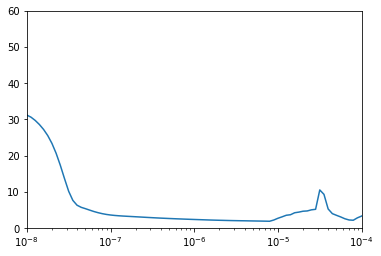

In [19]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])
plt.show()

## 2. Learning rate = 1e-6

In [49]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
25/25 [==============================] - 0s 15ms/step - loss: 13.0658 - mae: 13.5571
Epoch 2/500
25/25 [==============================] - 0s 15ms/step - loss: 3.7048 - mae: 4.1789
Epoch 3/500
25/25 [==============================] - 0s 16ms/step - loss: 2.6464 - mae: 3.1105
Epoch 4/500
25/25 [==============================] - 0s 15ms/step - loss: 2.4258 - mae: 2.8870
Epoch 5/500
25/25 [==============================] - 0s 16ms/step - loss: 2.3119 - mae: 2.7710
Epoch 6/500
25/25 [==============================] - 0s 16ms/step - loss: 2.2309 - mae: 2.6885
Epoch 7/500
25/25 [==============================] - 0s 15ms/step - loss: 2.1713 - mae: 2.6279
Epoch 8/500
25/25 [==============================] - 0s 15ms/step - loss: 2.1266 - mae: 2.5823
Epoch 9/500
25/25 [==============================] - 0s 16ms/step - loss: 2.0909 - mae: 2.5458
Epoch 10/500
25/25 [==============================] - 0s 16ms/step - loss: 2.0620 - mae: 2.5162
Epoch 11/500
25/25 [===========================

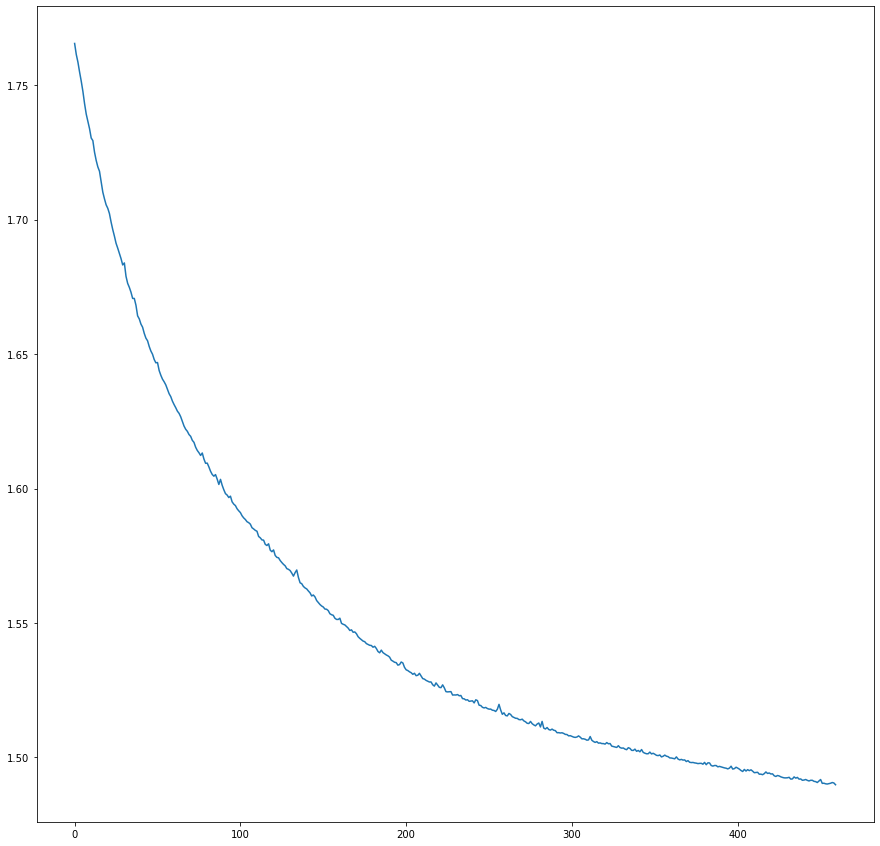

In [50]:
plt.figure(figsize=(15,15))
plt.plot(history.history['loss'][40:])
plt.show()

In [51]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

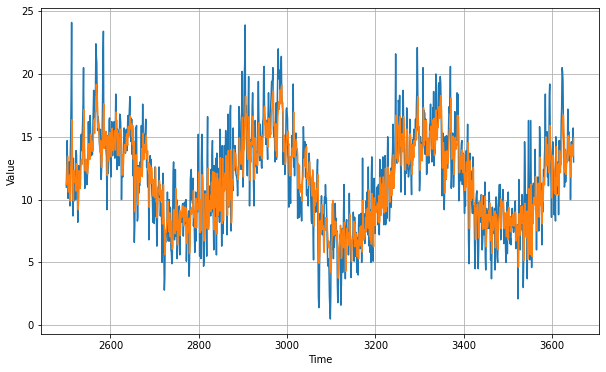

In [52]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid[-len(rnn_forecast):])
plot_series(time_valid, rnn_forecast)

In [53]:
tf.keras.metrics.mean_absolute_error(x_valid[-len(rnn_forecast):], rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.8126079

In [54]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.196514 11.48416  12.746117 ... 13.457048 13.505629 14.890859]
